# Bonus 1: Numerical Optimization for Logistic Regression.

### Name: [Bowen Li]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance. (1 bonus point.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Github repo.

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2019F/blob/master/homework/Bonus1/Bonus1.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [26]:
from sklearn import datasets
import numpy as np
import numpy
x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [27]:
# partition the data to training and test sets
n = x.shape[0]
n_train = int(numpy.ceil(n * 0.8))
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (615, 8)
Shape of x_test: (153, 8)
Shape of y_train: (615, 1)
Shape of y_test: (153, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [28]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.01373012 -0.09133437 -0.11998752 -0.01047389 -0.09323957 -0.17048024
  -0.07118078  0.10323425]]
test std = 
[[0.96205941 1.03420029 1.30363281 1.09149882 1.02063872 1.01609856
  1.01633015 1.01277462]]


## 1.4. Add a dimension of all ones

In [29]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (615, 9)
Shape of x_test: (153, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [30]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [31]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [32]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [33]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [34]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5799439842031044
Objective value at t=2 is 0.5338971116826243
Objective value at t=3 is 0.5091675669821265
Objective value at t=4 is 0.4937294419251314
Objective value at t=5 is 0.48324330206799454
Objective value at t=6 is 0.4757350645880443
Objective value at t=7 is 0.47016183548523843
Objective value at t=8 is 0.46591434099300066
Objective value at t=9 is 0.4626106682494847
Objective value at t=10 is 0.4599988437718192
Objective value at t=11 is 0.4579060592063996
Objective value at t=12 is 0.4562101387718768
Objective value at t=13 is 0.45482254301447866
Objective value at t=14 is 0.45367777024587175
Objective value at t=15 is 0.4527265007278979
Objective value at t=16 is 0.4519310267825356
Objective value at t=17 is 0.4512621290388038
Objective value at t=18 is 0.4506968946811992
Objective value at t=19 is 0.4502171646954144
Objective value at t=20 is 0.4498084101890947
Objective value at t=21 is 0.4494589069

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [35]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [36]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [37]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.515408366001649
Objective value at epoch t=1 is 0.48996692284087445
Objective value at epoch t=2 is 0.48030028465087515
Objective value at epoch t=3 is 0.48814214839643966
Objective value at epoch t=4 is 0.4740095116571746
Objective value at epoch t=5 is 0.4752356098233777
Objective value at epoch t=6 is 0.47439953258711826
Objective value at epoch t=7 is 0.47047101008751774
Objective value at epoch t=8 is 0.4681632770895683
Objective value at epoch t=9 is 0.4657133503859001
Objective value at epoch t=10 is 0.46126689283969546
Objective value at epoch t=11 is 0.46556765974705944
Objective value at epoch t=12 is 0.46364238357567805
Objective value at epoch t=13 is 0.45945379143426684
Objective value at epoch t=14 is 0.4594403179939692
Objective value at epoch t=15 is 0.45819537674000566
Objective value at epoch t=16 is 0.4549605398422861
Objective value at epoch t=17 is 0.45796629967978186
Objective value at epoch t=18 is 0.4560754829236686
Objective va

# 4. Compare GD with SGD

Plot objective function values against epochs.

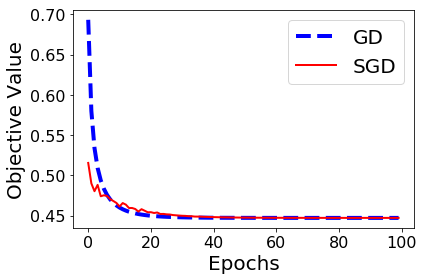

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [39]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [40]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2097560975609756


In [41]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.2549019607843137


# 6. Mini-batch SGD (fill the code)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

In [47]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    d = xi.shape[0]
    addloss = 0
    addgloss = 0
    for i in range(0, d, b):
        x_i = xi[i:i+b,:]
        yx = yi*x_i
        w_i = w[:,i:i+b] 
        yxw = numpy.dot(yx, w_i) # vector
        loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
        g_loss = -yx.T / (1 + numpy.exp(yxw))
        addloss += loss
        addgloss += g_loss
    return addloss, addgloss
    
    reg = lam / 2 * numpy.sum(w * w) # scalar
    
    obj = addloss/b + reg
    g = addgloss/b + lam * w # d-by-1 matrix
    
    return obj, g

## 6.2. Implement mini-batch SGD

In [48]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    ...
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float (y_rand[i, :]) # vector
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

## 6.3. Run MB-SGD

In [49]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is [[0.51093606]]
Objective value at epoch t=1 is [[0.48580574]]
Objective value at epoch t=2 is [[0.47953602]]
Objective value at epoch t=3 is [[0.48516419]]
Objective value at epoch t=4 is [[0.48249867]]
Objective value at epoch t=5 is [[0.47249127]]
Objective value at epoch t=6 is [[0.47258122]]
Objective value at epoch t=7 is [[0.47304351]]
Objective value at epoch t=8 is [[0.47056722]]
Objective value at epoch t=9 is [[0.46356689]]
Objective value at epoch t=10 is [[0.46664409]]
Objective value at epoch t=11 is [[0.46379242]]
Objective value at epoch t=12 is [[0.46314557]]
Objective value at epoch t=13 is [[0.46083967]]
Objective value at epoch t=14 is [[0.46041629]]
Objective value at epoch t=15 is [[0.45813195]]
Objective value at epoch t=16 is [[0.45496201]]
Objective value at epoch t=17 is [[0.45725536]]
Objective value at epoch t=18 is [[0.45632947]]
Objective value at epoch t=19 is [[0.45350167]]
Objective value at epoch t=20 is [[0.45434789]]
Ob

In [50]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is [[0.49977024]]
Objective value at epoch t=1 is [[0.50025178]]
Objective value at epoch t=2 is [[0.48155778]]
Objective value at epoch t=3 is [[0.47961291]]
Objective value at epoch t=4 is [[0.48031974]]
Objective value at epoch t=5 is [[0.484569]]
Objective value at epoch t=6 is [[0.47583135]]
Objective value at epoch t=7 is [[0.46644796]]
Objective value at epoch t=8 is [[0.47545907]]
Objective value at epoch t=9 is [[0.46584788]]
Objective value at epoch t=10 is [[0.46207267]]
Objective value at epoch t=11 is [[0.46442947]]
Objective value at epoch t=12 is [[0.46151071]]
Objective value at epoch t=13 is [[0.46014752]]
Objective value at epoch t=14 is [[0.46177382]]
Objective value at epoch t=15 is [[0.45583062]]
Objective value at epoch t=16 is [[0.45852486]]
Objective value at epoch t=17 is [[0.45674361]]
Objective value at epoch t=18 is [[0.45650466]]
Objective value at epoch t=19 is [[0.45361448]]
Objective value at epoch t=20 is [[0.454585]]
Object

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

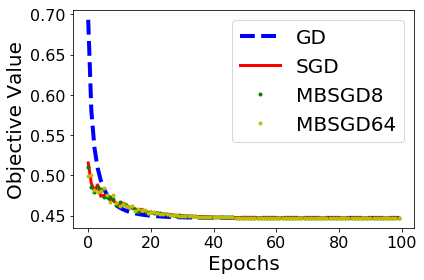

In [52]:
# plot the 4 curves:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mb_sgd = range(len(objvals_mbsgd8))
epochs_mb_sgd = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=3)
line2, = plt.plot(epochs_mb_sgd, objvals_mbsgd8, 'g.', LineWidth=2)
line3, = plt.plot(epochs_mb_sgd, objvals_mbsgd64, 'y.', LineWidth=1)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD','MBSGD8','MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)